In [23]:
import os, pickle, warnings
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import torch
from transformers import BertTokenizer, BertModel

warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- paths ---
BASE_PATH = "/content/"

# --- reproducibility ---
np.random.seed(42)

# --- device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cpu'

In [24]:
# Load EXP3
with open(f"{BASE_PATH}/EXP3.pkl", "rb") as f:
    exp3 = pickle.load(f)

X_exp3 = np.asarray(exp3["Fmridata"], dtype=np.float32)   # (243, n_vox)

# GloVe sentence vectors
Y_glove = np.loadtxt(f"{BASE_PATH}/vectors_243sentences.GV42B300.average.txt")  # (243, 300)

# Sentences for embedding
raw_sentences = exp3["keySentences"]
sentences = [s[0][0] if isinstance(s, (list, tuple)) else str(s) for s in raw_sentences]


print("Shapes ->  X_exp3(fMRI):", X_exp3.shape, "  GloVe:", Y_glove.shape, "  sentences:", len(sentences))
print("Sample sentence:", sentences[0][:80], "...")


Shapes ->  X_exp3(fMRI): (243, 185866)   GloVe: (243, 300)   sentences: 243
Sample sentence: [array(['Beekeeping encourages the conservation of local habitats.'],
       dty ...


In [25]:
# Load pretrained BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(DEVICE)
model.eval()

# Generate BERT sentence embeddings (mean-pooled last hidden state)
bert_vectors = []
with torch.no_grad():
    for sentence in tqdm(sentences, desc="Extracting BERT embeddings"):
        # keep their truncation/max_length behavior and per-sentence loop
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512).to(DEVICE)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        bert_vectors.append(cls_embedding)

Y_bert = np.vstack(bert_vectors).astype(np.float32)
print("BERT embeddings shape:", Y_bert.shape)


Extracting BERT embeddings: 100%|██████████| 243/243 [01:02<00:00,  3.88it/s]

BERT embeddings shape: (243, 768)


In [26]:
def single_compute_voxel_r2(v, X_train, X_test, Y_train, Y_test):
    mdl = LinearRegression()
    y_tr = Y_train[:, v]
    y_te = Y_test[:, v]
    mdl.fit(X_train, y_tr)
    y_pred = mdl.predict(X_test)
    return r2_score(y_te, y_pred)

def compute_voxel_r2(X_features, Y_fmri, method_label, test_size=0.2, random_state=42, n_jobs=-1):
    n_voxels = Y_fmri.shape[1]
    X_tr, X_te, Y_tr, Y_te = train_test_split(X_features, Y_fmri, test_size=test_size, random_state=random_state)
    voxels = list(range(n_voxels))
    r2_scores = Parallel(n_jobs=n_jobs)(
        delayed(single_compute_voxel_r2)(v, X_tr, X_te, Y_tr, Y_te)
        for v in tqdm(voxels, desc=f"Encoding ({method_label})")
    )
    return np.array(r2_scores, dtype=np.float32)

# Run for GloVe and BERT
r2_glove = compute_voxel_r2(Y_glove, X_exp3, "GloVe")
r2_bert  = compute_voxel_r2(Y_bert,  X_exp3, "BERT")

print("Done. R² arrays:", r2_glove.shape, r2_bert.shape)


Encoding (BERT): 100%|██████████| 185866/185866 [41:24<00:00, 74.82it/s]


Done. R² arrays: (185866,) (185866,)


GloVe:
  Total voxels: 185866
  Voxels with R² > 0: 2 (0.00%)
  Mean R² (positive only): 0.0310

BERT:
  Total voxels: 185866
  Voxels with R² > 0: 274 (0.15%)
  Mean R² (positive only): 0.0674



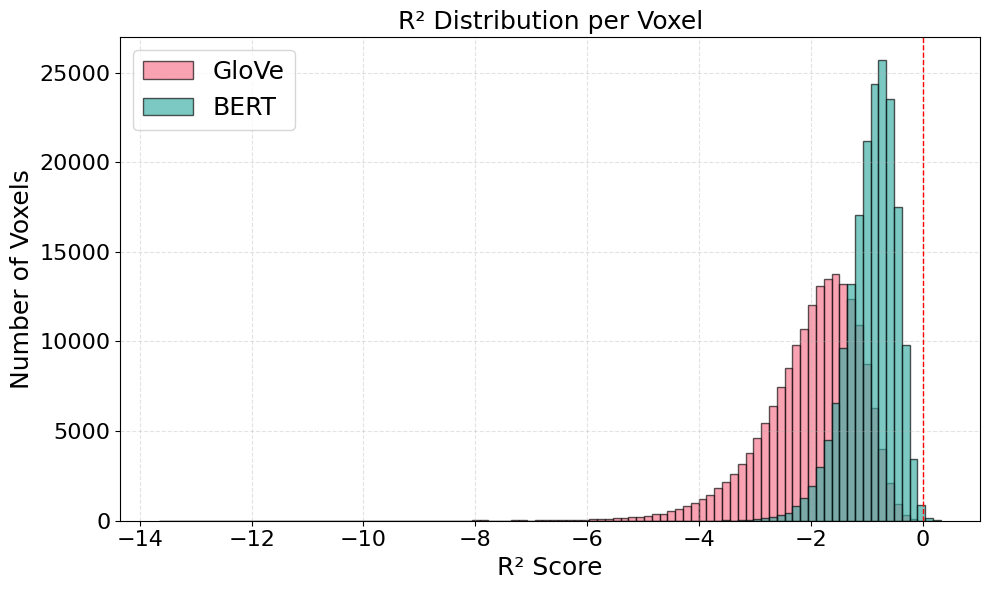

/tmp/ipython-input-3757316759.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


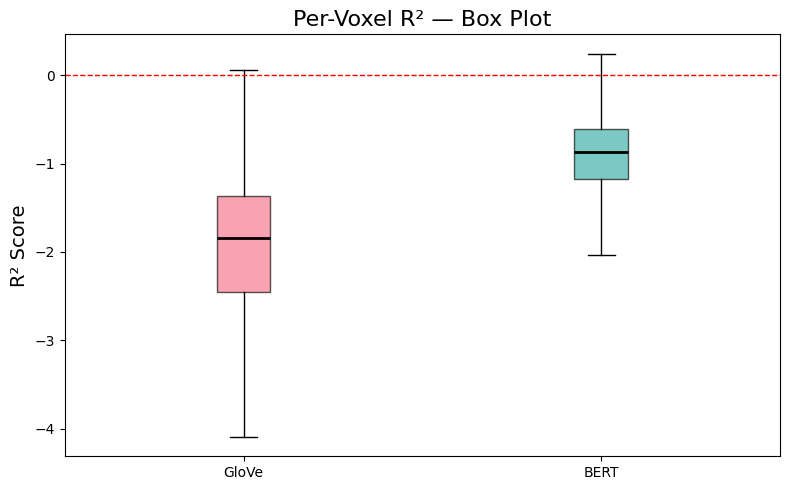

In [28]:
import seaborn as sns

def summarize_r2_dual_fixed(r2_1, label_1, r2_2, label_2, bins=100):
    c1, c2 = sns.color_palette("husl", 2)

    def print_stats(r2, label):
        n_total = len(r2)
        n_pos = int(np.sum(r2 > 0))
        mean_pos = float(np.mean(r2[r2 > 0]) if n_pos > 0 else 0.0)
        print(f"{label}:\n  Total voxels: {n_total}\n  Voxels with R² > 0: {n_pos} ({n_pos / n_total:.2%})\n  Mean R² (positive only): {mean_pos:.4f}\n")

    print_stats(r2_1, label_1)
    print_stats(r2_2, label_2)

    # shared bins
    r2_min = float(min(np.min(r2_1), np.min(r2_2)))
    r2_max = float(max(np.max(r2_1), np.max(r2_2)))
    bin_edges = np.linspace(r2_min, r2_max, bins + 1)

    plt.figure(figsize=(10, 6))
    plt.hist(r2_1, bins=bin_edges, alpha=0.65, label=label_1, edgecolor='black', color=c1)
    plt.hist(r2_2, bins=bin_edges, alpha=0.65, label=label_2, edgecolor='black', color=c2)
    plt.axvline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel("R² Score", fontsize=18)
    plt.ylabel("Number of Voxels", fontsize=18)
    plt.title("R² Distribution per Voxel", fontsize=18)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.legend(fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.35)
    plt.tight_layout()
    plt.show()


def r2_boxplot(r2_a, label_a, r2_b, label_b, showfliers=False):
    """Box plot of per-voxel R² for two models with HUSL colors."""
    c1, c2 = sns.color_palette("husl", 2)
    data = [np.asarray(r2_a, dtype=float), np.asarray(r2_b, dtype=float)]

    plt.figure(figsize=(8, 5))
    bp = plt.boxplot(
        data,
        labels=[label_a, label_b],
        showfliers=showfliers,
        patch_artist=True
    )

    for patch, c in zip(bp['boxes'], [c1, c2]):
        patch.set_facecolor(c)
        patch.set_alpha(0.65)
        patch.set_edgecolor("black")

    # keep outlines consistent
    for whisker in bp['whiskers']: whisker.set_color("black")
    for cap in bp['caps']: cap.set_color("black")
    for median in bp['medians']:
        median.set_color("black")
        median.set_linewidth(2)

    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.ylabel("R² Score", fontsize=14)
    plt.title("Per-Voxel R² — Box Plot", fontsize=16)
    plt.tight_layout()
    plt.show()


summarize_r2_dual_fixed(r2_glove, "GloVe", r2_bert, "BERT")
r2_boxplot(r2_glove, "GloVe", r2_bert, "BERT", showfliers=False)
